In [1]:
# Jason Wang
# December 10th, 2021

### Imports and Declarations

In [1]:
import cv2
import mediapipe as mp
import os
from scipy.stats import norm
from scipy.signal import savgol_filter
import math
import numpy as np
import urllib
import time
import threading
import matplotlib.pyplot as plt 
from scipy.interpolate import barycentric_interpolate
from scipy import interpolate
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

### Functions

In [2]:
def getAngle3D(results, a, b, c):
    """
    Calculates the angle between three points baed on the number given in the figure
    
    Parameters:
    results : Processed Mediapipe
    a (int): Number given to the first joint 
    b (int): Number given to the second or main joint 
    c (int): Number given to the third joint
    
    Returns:
    output: The angle rounded to two decimal points
    """
    
    v1 = [results.pose_landmarks.landmark[a].x - results.pose_landmarks.landmark[b].x,
          results.pose_landmarks.landmark[a].y - results.pose_landmarks.landmark[b].y,
          results.pose_landmarks.landmark[a].z - results.pose_landmarks.landmark[b].z]
    v2 = [results.pose_landmarks.landmark[c].x - results.pose_landmarks.landmark[b].x,
          results.pose_landmarks.landmark[c].y - results.pose_landmarks.landmark[b].y,
          results.pose_landmarks.landmark[c].z - results.pose_landmarks.landmark[b].z]
    v1mag = np.sqrt(np.square(v1[0]) + np.square(v1[1]) + np.square(v1[2]))
    v2mag = np.sqrt(np.square(v2[0]) + np.square(v2[1]) + np.square(v2[2]))
    v1norm = [x / v1mag for x in v1]
    v2norm = [x / v2mag for x in v2]
    res = v1norm[0]*v2norm[0] + v1norm[1]*v2norm[1] + v1norm[2]*v2norm[2]
    output = np.arccos(res)
    angle = round(math.degrees(output),2)
    return angle 

In [3]:
def getAngle(results, a, b, c):
    """
    Calculates the angle between three points baed on the number given in the figure using just 
    the x and y coordinates
    
    
    Parameters:
    results : Processed Mediapipe
    a (int): Number given to the first joint 
    b (int): Number given to the second or main joint 
    c (int): Number given to the third joint
    
    Returns:
    output: The angle rounded to two decimal points
    """
    v1 = [results.pose_landmarks.landmark[b].x - results.pose_landmarks.landmark[a].x,
          results.pose_landmarks.landmark[b].y - results.pose_landmarks.landmark[a].y]
    v2 = [results.pose_landmarks.landmark[b].x - results.pose_landmarks.landmark[c].x,
          results.pose_landmarks.landmark[b].y - results.pose_landmarks.landmark[c].y]
    dot = v1[0] * v2[0] + v1[1] * v2[1]
    v1mag = np.sqrt(np.square(v1[0]) + np.square(v1[1]))
    v2mag = np.sqrt(np.square(v2[0]) + np.square(v2[1]))
    res = dot/(v1mag * v2mag)
    output = np.arccos(res)
    angle = round(math.degrees(output),2)
    return angle 
    

In [4]:
def getCoordinate(results, b):
    """
    Returns the coordinate of the second or main joint
    
    Parameters:
    results : Processed Mediapipe
    b (int): Number given to the second or main joint 
    
    Returns:
    coordinate: The x, y coordinate of the second or main joint
    """
    coordinate = [results.pose_landmarks.landmark[b].x, results.pose_landmarks.landmark[b].y]
    return coordinate

In [5]:
def getVisibility(results, a, b, c):
    """
    Calculates the visibility between three points baed on the number given in the figure by averaging the all the visibility values
    
    Parameters:
    results : Processed Mediapipe
    a (int): Number given to the first joint 
    b (int): Number given to the second or main joint 
    c (int): Number given to the third joint
    
    Returns:
    visibility: The average visibility of all the joints
    """
    output = (results.pose_landmarks.landmark[a].visibility + results.pose_landmarks.landmark[b].visibility + results.pose_landmarks.landmark[c].visibility)/3
    visibility = round(output,2)
    return visibility

In [6]:
def normalizeAngles(results):
    """
    Returns the angles of the most important joints in the body during the motion.
    
    Parameters:
    results : Processed Mediapipe image
    
    Returns:
    output : List of angle values ordered by [right hand, left hand, right elbow, left elbow, right hip, left hip, right knee, left knee, right foot, left foot]
    
    """
    rightHand = getAngle(results, 20, 16, 14)
    leftHand = getAngle(results, 19, 15, 13)
    rightElbow = getAngle(results, 16, 14, 12)
    leftElbow = getAngle(results, 15, 13, 11)
    rightHip = getAngle(results, 26, 24, 12)
    leftHip = getAngle(results, 25, 23, 11)
    rightKnee = getAngle(results, 28, 26 ,24)
    leftKnee = getAngle(results, 27, 25, 23)
    rightFoot = getAngle(results, 32, 28, 26)
    leftFoot = getAngle(results, 31, 27, 25)
    output = [rightHand, leftHand, rightElbow, leftElbow, rightHip, leftHip, rightKnee, leftKnee, rightFoot, leftFoot]
    return output

In [7]:
def initiateList():
    output = [[],[],[],[],[],[],[],[],[],[]]
    return output

In [8]:
def normalizeAngles(results, listAngles):
    """
    Returns the angles of the most important joints in the body during the motion.
    
    Parameters:
    listAngles
    results : Processed Mediapipe image
    
    Returns:
    output : List of angle values ordered by [right hand, left hand, right elbow, left elbow, right hip, left hip, right knee, left knee, right foot, left foot]
    
    """
    listAngles[0].append(getAngle(results, 20, 16, 14))
    listAngles[1].append(getAngle(results, 19, 15, 13))
    listAngles[2].append(getAngle(results, 16, 14, 12))
    listAngles[3].append(getAngle(results, 15, 13, 11))
    listAngles[4].append(getAngle(results, 26, 24, 12))
    listAngles[5].append(getAngle(results, 25, 23, 11))
    listAngles[6].append(getAngle(results, 28, 26 ,24))
    listAngles[7].append(getAngle(results, 27, 25, 23))
    listAngles[8].append(getAngle(results, 32, 28, 26))
    listAngles[9].append(getAngle(results, 31, 27, 25))
    return True

In [9]:
def normalizeVisibilities(results, listVisibilities):
    """
    Returns the angles of the most important joints in the body during the motion.
    
    Parameters:
    results : Processed Mediapipe image
    
    Returns:
    output : List of angle values ordered by [right hand, left hand, right elbow, left elbow, right hip, left hip, right knee, left knee, right foot, left foot]
    
    """
    listVisibilities[0].append(getVisibility(results, 20, 16, 14))
    listVisibilities[1].append(getVisibility(results, 19, 15, 13))
    listVisibilities[2].append(getVisibility(results, 16, 14, 12))
    listVisibilities[3].append(getVisibility(results, 15, 13, 11))
    listVisibilities[4].append(getVisibility(results, 26, 24, 12))
    listVisibilities[5].append(getVisibility(results, 25, 23, 11))
    listVisibilities[6].append(getVisibility(results, 28, 26 ,24))
    listVisibilities[7].append(getVisibility(results, 27, 25, 23))
    listVisibilities[8].append(getVisibility(results, 32, 28, 26))
    listVisibilities[9].append(getVisibility(results, 31, 27, 25))
    return True

In [10]:
def listVisibilities(results, angles):
    """
    Returns the angles of the most important joints in the body during the motion.
    
    Parameters:
    results : Processed Mediapipe image
    
    Returns:
    output : List of angle values ordered by [right hand, left hand, right elbow, left elbow, right hip, left hip, right knee, left knee, right foot, left foot]
    
    """
    rightHand = getVisibility(results, 20, 16, 14)
    leftHand = getVisibility(results, 19, 15, 13)
    rightElbow = getVisibility(results, 16, 14, 12)
    leftElbow = getVisibility(results, 15, 13, 11)
    rightHip = getVisibility(results, 26, 24, 12)
    leftHip = getVisibility(results, 25, 23, 11)
    rightKnee = getVisibility(results, 28, 26 ,24)
    leftKnee = getVisibility(results, 27, 25, 23)
    rightFoot = getVisibility(results, 32, 28, 26)
    leftFoot = getVisibility(results, 31, 27, 25)
    output = [rightHand, leftHand, rightElbow, leftElbow, rightHip, leftHip, rightKnee, leftKnee, rightFoot, leftFoot]
    return output

In [11]:
def savgolSmoothing(angles, window, poly):
    """
    Returns a list of angles that have been smoothed with Savitzky_golay Filtering
    
    Parameters:
    angles : List of raw angle values
    window : Int of how many frames to smooth by 
    poly: Polynomial of smoothing
    
    Returns:
    output : List of smoothed angle values
    
    """
    output = []
    for i in angles:
        output.append(savgol_filter(i, window, poly))
    return output

In [12]:
def distributionDifference(distOne, distTwo):
    diff = 0
    for i in range(len(distOne)):
        for j in range(len(distOne[i])):
            diff += math.pow((distOne[i][j]-distTwo[i][j]), 2)
    return diff

In [13]:
def reduceDistribution(dist, delayFrames, targetLength):
    temp = initiateList()
    for i in range(len(dist)):
        temp[i] = (dist[i][delayFrames:delayFrames+targetLength])
    return temp

In [14]:
def syncCameras(distOne, distTwo):
    """
    Returns the smallest difference in angles based on frames 
    Condition: Side must be small and fit into back
    
    Parameters:
    framesWebcam: A list of frames from the back
    framesPhone: A list of frames from the side
    
    Returns:
    output : The time difference between the two frames
    
    """
    frameDifference = len(distOne[0]) - len(distTwo[0])
    minDiff = math.pow(10, 10)
    frameDiff = 0
    start = 0
    end = len(distTwo[0])
    for i in range(frameDifference):
        reducedSide = reduceDistribution(distOne, i, len(distTwo[0]))
        difference = distributionDifference(reducedSide, sideAngles)
        if difference < minDiff:
            frameDiff = i
            minDiff = difference
            start = i
    return frameDiff

In [15]:
def combineDistributions(distOne, distTwo, visibilitiesOne, visibilitiesTwo):
    if (len(distOne[0]) != len(distTwo[0])):
        print('Distributions different length!')
        return False 
    if (len(visibilitiesOne[0]) != len(visibilitiesTwo[0])):
        print('Visibiilities different length!')
        return False 
    tempAngles = initiateList()
    tempVisibilities = initiateList()
    for i in range(len(distOne)):
        for j in range(len(distOne[i])):
            diff = distTwo[i][j] - distOne[i][j]
            combineVisibilities = visibilitiesOne[i][j] + visibilitiesTwo[i][j]
            tempVisibilities[i].append(combineVisibilities/2)
            percentage = visibilitiesTwo[i][j]/combineVisibilities
            change = diff * percentage
            tempAngles[i].append(distOne[i][j] + change)
    tempAngles = savgolSmoothing(tempAngles, 49, 3)
    return tempAngles, tempVisibilities

In [16]:
def changeDistribution(dist, size):
    x_observed = np.linspace(0.0, size, len(dist))
    y_observed = dist
    f = interpolate.interp1d(x_observed,y_observed)
    x = np.linspace(0, 1000, size)
    y = f(x).tolist()
    return y

In [17]:
def analyzeData(rootdir):
    masterAngles = []
    masterVisibilities = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            path = os.path.join(subdir, file)
            if path.endswith('.mp4'):
                video_cap = cv2.VideoCapture(path)
                videoAngles = initiateList()
                videoVisibilities = initiateList()
                video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
                videoCount = 0
                with mp_pose.Pose(static_image_mode=False,model_complexity=2,min_detection_confidence=0.0) as pose:
                    while video_cap.isOpened():
                        try:
                            video_ret, video_frame = video_cap.read()
                            video_result = pose.process(video_frame)
                            normalizeAngles(video_result, videoAngles)
                            normalizeVisibilities(video_result, videoVisibilities)
                            previous_video_result = video_result
                        except:
                            normalizeAngles(previous_video_result, videoAngles)
                            normalizeVisibilities(previous_video_result, videoVisibilities)
                            pass
                        videoCount += 1
                        if (videoCount >= video_n_frames):
                            break
                masterAngles.append(videoAngles)
                masterVisibilities.append(videoVisibilities)
    return masterAngles, masterVisibilities

                

In [18]:
def combineData(masterAngles, masterVisibilities):
    standardized = []
    count = 0
    standardizedAngles = []
    standardizedVisibilities = []
    for i in range(len(masterAngles)):
        tempAngles = []
        tempVisibilities = []
        for j in range(len(masterAngles[i])):
            tempAngles.append(changeDistribution(masterAngles[i][j], 1000))
            tempVisibilities.append(changeDistribution(masterVisibilities[i][j], 1000))
        standardizedAngles.append(tempAngles)
        standardizedVisibilities.append(tempVisibilities)
    combinedOneAngles, combinedOneVisibilities = combineDistributions(standardizedAngles[0], standardizedAngles[1], standardizedVisibilities[0], standardizedVisibilities[1])
    combinedTwoAngles, combinedTwoVisibilities = combineDistributions(standardizedAngles[2], standardizedAngles[3], standardizedVisibilities[2], standardizedVisibilities[3])
    combinedThreeAngles, combinedThreeVisibilities = combineDistributions(standardizedAngles[4], standardizedAngles[5], standardizedVisibilities[4], standardizedVisibilities[5])
    combinedFourAngles, combinedFourVisibilities = combineDistributions(standardizedAngles[6], standardizedAngles[7], standardizedVisibilities[6], standardizedVisibilities[7])
    combinedOneAngles, combinedOneVisibilities = combineDistributions(combinedOneAngles, combinedTwoAngles, combinedOneVisibilities, combinedTwoVisibilities)
    combinedTwoAngles, combinedTwoVisibilities = combineDistributions(combinedThreeAngles, combinedFourAngles, combinedThreeVisibilities, combinedFourVisibilities)
    dataAngles, dataVisibilities = combineDistributions(combinedOneAngles, combinedTwoAngles, combinedOneVisibilities, combinedTwoVisibilities)
    dataAngles = savgolSmoothing(dataAngles, 49, 3)
    dataVisibilities = savgolSmoothing(dataVisibilities, 49, 3)
    return dataAngles, dataVisibilities
            

In [19]:
def matchFinal(distOne, distTwo):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-19-a76681e7b53a>, line 2)

### Analyzing Videos

In [15]:
# Video Characteristics
video_path = '/Users/jasonwang/Academics/Data Science/Personal Projects/myTennis/'
back = 'back.mp4'
side = 'side.mp4'
side_cap = cv2.VideoCapture(video_path + side)
back_cap = cv2.VideoCapture(video_path + back)
#video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
side_cap.get(cv2.CAP_PROP_FPS)
#video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

119.83866243679005

In [19]:
video_path = '/Users/jasonwang/Academics/Data Science/Personal Projects/myTennis/'
back = 'back.mp4'
side = 'side.mp4'
side_cap = cv2.VideoCapture(video_path + side)
back_cap = cv2.VideoCapture(video_path + back)
back_n_frames = back_cap.get(cv2.CAP_PROP_FRAME_COUNT)
side_n_frames = side_cap.get(cv2.CAP_PROP_FRAME_COUNT)
backAngles = initiateList()
sideAngles = initiateList()
backVisibilities = initiateList()
sideVisibilities = initiateList()
backCount = 0
sideCount = 0
with mp_pose.Pose(static_image_mode=False,model_complexity=2,min_detection_confidence=0.0) as pose:
    while back_cap.isOpened() or side_cap.isOpened():
        try:
            back_ret, back_frame = back_cap.read()
            back_result = pose.process(back_frame)
            normalizeAngles(back_result, backAngles)
            normalizeVisibilities(back_result, backVisibilities)
            previous_back_result = back_result
        except:
            normalizeAngles(previous_back_result, backAngles)
            normalizeVisibilities(previous_back_result, backVisibilities)
            pass
        backCount += 1
        if (backCount >= back_n_frames):
            break
with mp_pose.Pose(static_image_mode=False,model_complexity=2,min_detection_confidence=0.0) as pose:
    while back_cap.isOpened() or side_cap.isOpened():
        try:
            side_ret, side_frame = side_cap.read()
            side_result = pose.process(side_frame)
            normalizeAngles(side_result, sideAngles)
            normalizeVisibilities(side_result, sideVisibilities)
            previous_side_result = side_result
        except:
            normalizeAngles(previous_side_result, sideAngles)
            normalizeVisibilities(previous_side_result, sideVisibilities)
            pass
        sideCount += 1
        if sideCount >= side_n_frames:
            break
back_cap.release()
side_cap.release()
cv2.destroyAllWindows()

In [20]:
print(len(backAngles[0]))
print(back_n_frames)
print(side_n_frames)
print(len(sideAngles[0]))

982
982.0
566.0
566


In [31]:
smoothedBack = savgolSmoothing(backAngles, 49, 3)
smoothedSide = savgolSmoothing(sideAngles, 49, 3)
video_path = '/Users/jasonwang/Academics/Data Science/Personal Projects/myTennis/'
back = 'back.mp4'
side = 'side.mp4'
side_cap = cv2.VideoCapture(video_path + side)
back_cap = cv2.VideoCapture(video_path + back)
back_n_frames = back_cap.get(cv2.CAP_PROP_FRAME_COUNT)
side_n_frames = side_cap.get(cv2.CAP_PROP_FRAME_COUNT)
delay = syncCameras(smoothedBack, smoothedSide)
count = 0
while count < delay:
    back_ret, back_frame = back_cap.read()
    count += 1
while back_cap.isOpened() or side_cap.isOpened():
    back_ret, back_frame = back_cap.read()
    side_ret, side_frame = side_cap.read()
    if not back_ret and not side_ret:
        print("Can't receive frame (stream end?). Exiting ...")
        continue
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    if key == ord('p'):
        cv2.waitKey(-1) 
    try:
        combined = np.concatenate((back_frame, side_frame), axis=1)
        cv2.imshow('frame', combined)
    except:
        break
back_cap.release()
side_cap.release()
cv2.destroyAllWindows()

In [21]:
reducedBackAngles = reduceDistribution(smoothedBack, delay, len(sideAngles[0]))
reducedBackVisibilities = reduceDistribution(backVisibilities, delay, len(sideVisibilities[0]))

In [22]:
combinedAngles, combinedVisibilities = combineDistributions(reducedBackAngles, smoothedSide, reducedBackVisibilities, sideVisibilities)

In [23]:
path = "/Users/jasonwang/Academics/Data Science/Personal Projects/Data/"
Angles, Visibilities = analyzeData(path)

In [24]:
federerAngles, federerVisibilities = combineData(Angles, Visibilities)

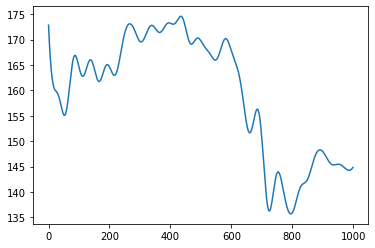

In [34]:

plt.plot(federerAngles[1])
plt.show()

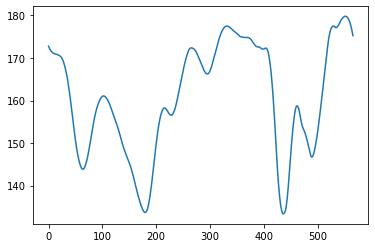

In [35]:
plt.plot(combinedAngles[1])

In [39]:
expandedAngles = []
for i in range(len(combinedAngles)):
    temp = changeDistribution(combinedAngles[i], 2000)
    expandedAngles.append(temp)

In [41]:
print(syncCameras(combinedAngles, federerAngles))

0


In [52]:
myselfPath = "/Users/jasonwang/Academics/Data Science/Personal Projects/example/side.mp4"
federerPath = "/Users/jasonwang/Academics/Data Science/Personal Projects/example/clipTen.mp4"
myself_cap = cv2.VideoCapture(myselfPath)
federer_cap = cv2.VideoCapture(federerPath)
delay = calculateDelay
count = 0
while count < delay:
    myself_ret, myself_frame = myself_cap.read()
    count += 1
with mp_pose.Pose(static_image_mode=False,model_complexity=0,min_detection_confidence=0.5) as pose:
    while myself_cap.isOpened():
        myself_ret, myself_frame = myself_cap.read()
        federer_ret, federer_frame = federer_cap.read()
        if not myself_ret or not federer_ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
        if key == ord('p'):
            cv2.waitKey(-1) #wait until any key is pressed
            #webcam_frame = cv2.resize(webcam_frame, (176,144), interpolation = cv2.INTER_AREA)
        myself_image = cv2.cvtColor(myself_frame, cv2.COLOR_BGR2RGB)
        federer_image = cv2.cvtColor(federer_frame, cv2.COLOR_BGR2RGB)
        myself_image.flags.writeable = False
        federer_image.flags.writeable = False
        try:
            myself_processed = pose.process(myself_image)
            federer_processed = pose.process(federer_image)
            angle = getAngle(myself_processed, 28,26,24)
            knee = [myself_processed[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,myself_processed[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            myself_image.flags.writeable = True
            federer_image.flags.writeable = True

            cv2.putText(myself_image, str(angle), 
                        tuple(np.multiply(knee, [1280, 720]).astype(int)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                    )
            mp_drawing.draw_landmarks(myself_image, myself_processed.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                            )
            mp_drawing.draw_landmarks(federer_image, federer_processed.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                            )
        except:
            pass
        myself_image = cv2.cvtColor(myself_image, cv2.COLOR_RGB2BGR)
        federer_image = cv2.cvtColor(federer_image, cv2.COLOR_RGB2BGR)
        resized = cv2.resize(myself_image,(1280,720),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        combined = np.concatenate((resized, federer_image), axis=1)
        cv2.imshow('frame', combined)

Can't receive frame (stream end?). Exiting ...


In [33]:
federer_cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

720.0

In [104]:
smoothedPhone[0]

[array([173.07742857, 173.68828571, 172.08057143, 169.58114286,
        168.05885714, 113.15342857,  74.17285714,  96.94771429,
        168.604     , 153.37571429, 133.93314286, 131.51342857,
        159.20171429, 152.29714286, 164.11514286, 174.46285714,
        166.39257143, 147.95771429, 147.88857143, 166.87314286,
        169.70542857, 168.32257143, 167.82885714, 173.65685714,
        168.63314286, 173.95028571, 117.00685714, 104.35485714,
        127.56628571, 142.434     , 139.046     , 105.538     ,
         76.51314286,  73.31514286, 126.72485714, 149.41857143,
        120.97028571, 149.16342857, 137.86114286, 112.11914286,
         77.21857143, 112.85742857, 108.46628571, 112.78057143,
        136.86142857, 191.86371429, 147.36371429, 124.89      ,
        132.89628571, 170.18171429, 163.69      , 165.70485714,
        170.18342857, 173.56942857, 171.16142857, 173.37114286,
        176.43342857, 179.868     , 178.62228571, 177.28942857,
        176.942     , 178.60057143, 179.

In [62]:
with mp_pose.Pose(static_image_mode=False,model_complexity=2,min_detection_confidence=0.5) as pose:
    while video_cap.isOpened():
        ret, frame = video_cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
        if key == ord('p'):
            cv2.waitKey(-1) #wait until any key is pressed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        #try:
            
#             angle = getAngle(24,26,28)
#             point = getCoordinate(26)
#             visible = getVisibility(24,26,28)
#             cv2.putText(image, str(angle) + "  " + str(visible), 
#                     tuple(np.multiply(point, [video_width, video_height]).astype(int)), 
#                     cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA) 
#             visible, point, angle = getAngle(11,13,15)
#             cv2.putText(image, str(angle) + " " + str(visible), 
#                     tuple(np.multiply(point, [video_width, video_height]).astype(int)), 
#                     cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)   
        #except:
            #pass
#         mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
#                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
#                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
#                             )
        cv2.imshow('frame', image)
video_cap.release()
cv2.destroyAllWindows()



In [51]:
import numpy as np
calculateDelay = 275

### Phone Video 

In [53]:
with mp_pose.Pose(static_image_mode=False,model_complexity=1,min_detection_confidence=0.5) as pose:
    while video_cap.isOpened():
        ret, frame = video_cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
        if key == ord('p'):
            cv2.waitKey(-1) #wait until any key is pressed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        try:
            
            visible, point, angle = getAngle(24,26,28)
            cv2.putText(image, str(angle) + "  " + str(visible), 
                    tuple(np.multiply(point, [video_width, video_height]).astype(int)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA) 
            visible, point, angle = getAngle(11,13,15)
            cv2.putText(image, str(angle) + " " + str(visible), 
                    tuple(np.multiply(point, [video_width, video_height]).astype(int)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)  
            print(angle, visible, point)
        except:
            pass
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                            )
        cv2.imshow('frame', image)
    video_cap.release()
    cv2.destroyAllWindows()

### Webcam

In [64]:
video_cap = cv2.VideoCapture(0)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
count = 0 
webcam_result = cv2.VideoWriter('webcam.mp4', 
                         cv2.VideoWriter_fourcc(*'DIVX'),
                         fps, size)
listOfAngles = initiateList()
with mp_pose.Pose(static_image_mode=False,model_complexity=1) as pose:
    while video_cap.isOpened():
        ret, frame = video_cap.read()
        # if frame is read correctly ret is True
        webcam_result.write(frame)
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
        if key == ord('p'):
            cv2.waitKey(-1) #wait until any key is pressed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        try:
            processed = pose.process(image)
#         angle = getAngle(processed, 12,14,16)
#         visible = getVisibility(processed, 12, 14, 16)
#         point = getCoordinate(processed, 14)
#         cv2.putText(image, str(angle) + "  " + str(visible), 
#                     tuple(np.multiply(point, [video_width, video_height]).astype(int)), 
#                     cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA) 
        # Recolor back to BGR
            listAngles(listOfAngles, processed)
        except:
            pass
        
        
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


#         mp_drawing.draw_landmarks(image, processed.pose_landmarks, mp_pose.POSE_CONNECTIONS,
#                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
#                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
#                             )
        cv2.imshow('frame', image)
        count += 1
webcam_result.release()
print(listOfAngles)
video_cap.release()
cv2.destroyAllWindows()

[[164.46, 179.07, 167.53, 129.25, 176.01, 163.56, 112.59, 152.38, 15.68, 169.69, 161.59, 157.61, 60.52, 6.94, 165.8, 141.4, 170.42, 169.19, 124.46, 134.79, 150.98, 166.49, 172.64, 177.84, 176.5, 150.11, 163.28, 138.01, 87.58, 57.45, 5.05, 175.2, 178.1, 36.13, 165.22, 174.77, 172.4, 179.56, 178.94, 144.41, 155.33, 168.01, 173.78, 10.84, 75.2, 77.01, 126.02, 150.93, 120.33, 126.25, 109.27, 143.49, 153.01, 176.77, 115.01, 161.94, 105.29, 102.09, 103.59, 144.09, 139.33, 141.86, 142.54, 142.91, 136.99, 124.02, 123.65, 127.63, 124.51, 141.72, 125.14, 106.84, 146.52, 126.34, 161.1, 143.76, 177.51, 148.49, 146.13, 146.87, 152.77, 154.2, 53.4, 179.82, 177.6, 174.88, 172.79, 179.64, 173.47, 170.32, 169.49, 173.32, 170.69, 168.06, 175.67, 177.83, 178.13, 179.45, 163.38, 153.29, 173.07, 176.34, 179.54, 175.14, 163.57, 144.84, 144.18, 167.22, 145.82, 175.48, 173.46, 147.96, 167.0, 174.19, 158.23, 162.42, 167.54, 94.53, 169.56, 153.61, 155.45, 157.31], [172.08, 172.82, 163.8, 176.92, 154.19, 158.86,

## Combined Webcam and Phone Video

In [6]:
url = 'http://192.168.1.34:8080/video'
phone_cap = cv2.VideoCapture(url)   #25 FPS
webcam_cap = cv2.VideoCapture(0)   #30 FPS
size = (640,480)
fps = 25
phoneVideo = []
webcamVideo = []

#phone_result = cv2.VideoWriter('phone.mp4', 
#                         cv2.VideoWriter_fourcc(*'MP4V'),
#                         fps, size)
#webcam_result = cv2.VideoWriter('webcam.mp4', 
#                         cv2.VideoWriter_fourcc(*'MP4V'),
#                         fps, size)

start_time = time.time()
while webcam_cap.isOpened() or phone_cap.isOpened():
    phone_ret, phone_frame = phone_cap.read()
    webcam_ret, webcam_frame = webcam_cap.read()
    if not webcam_ret or not phone_ret:
        print("Can't receive frame (stream end?). Exiting ...")
        continue
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    if key == ord('p'):
        cv2.waitKey(-1) #wait until any key is pressed
    combined = np.concatenate((phone_frame, webcam_frame), axis=1)
    cv2.imshow('frame', combined)
    phoneVideo.append(phone_frame)
    webcamVideo.append(webcam_frame)
phone_cap.release()
webcam_cap.release()
cv2.destroyAllWindows()
print(len(phoneVideo))
print(len(webcamVideo))
print("--- %s seconds ---" % (time.time() - start_time))

1080
1080
--- 14.201597929000854 seconds ---


In [12]:
for image in phoneVideo:  
    cv2.imshow("frame", image)
    cv2.waitKey(1)

In [15]:
url = 'http://192.168.1.34:8080/video'
phone_cap = cv2.VideoCapture(url)   #25 FPS
webcam_cap = cv2.VideoCapture(0)   #30 FPS
phoneListOfAngles = initiateList()
webcamListOfAngles = initiateList()
with mp_pose.Pose(static_image_mode=False,model_complexity=1,min_detection_confidence=0.5) as pose:
    while webcam_cap.isOpened():
        phone_ret, phone_frame = phone_cap.read()
        webcam_ret, webcam_frame = webcam_cap.read()
        if not webcam_ret or not phone_ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
        if key == ord('p'):
            cv2.waitKey(-1) #wait until any key is pressed
            #webcam_frame = cv2.resize(webcam_frame, (176,144), interpolation = cv2.INTER_AREA)
        phone_image = cv2.cvtColor(phone_frame, cv2.COLOR_BGR2RGB)
        webcam_image = cv2.cvtColor(webcam_frame, cv2.COLOR_BGR2RGB)
        phone_image.flags.writeable = False
        phone_image.flags.writeable = False
        try:
            phone_processed = pose.process(phone_image)
            webcam_processed = pose.process(webcam_image)
            listAngles(phoneListOfAngles, phone_processed)
            listAngles(webcamListOfAngles, webcam_processed)
        except:
            pass
        phone_image.flags.writeable = True
        webcam_image.flags.writeable = True
        mp_drawing.draw_landmarks(phone_image, phone_processed.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                            )
        mp_drawing.draw_landmarks(webcam_image, webcam_processed.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                            )
        phone_image = cv2.cvtColor(phone_image, cv2.COLOR_RGB2BGR)
        webcam_image = cv2.cvtColor(webcam_image, cv2.COLOR_RGB2BGR)
        combined = np.concatenate((phone_image, webcam_image), axis=1)
        cv2.imshow('frame', combined)

phone_cap.release()
webcam_cap.release()
cv2.destroyAllWindows()
print(len(phoneListOfAngles[0]))
print(len(webcamListOfAngles[0]))
print(len(phoneListOfAngles[1]))
print(len(webcamListOfAngles[1]))

47
42
47
42


In [ ]:
url = 'http://192.168.1.185:8080/video'
phone_cap = cv2.VideoCapture(url)   #25 FPS
webcam_cap = cv2.VideoCapture(0)   #30 FPS
#webcam_cap.set(cv2.CAP_PROP_FPS, 25)
webcamcc = cv2.VideoWriter_fourcc(*'XVID')
with mp_pose.Pose(static_image_mode=False,model_complexity=1,min_detection_confidence=0.5) as pose:
    while webcam_cap.isOpened():
        phone_ret, phone_frame = phone_cap.read()
        webcam_ret, webcam_frame = webcam_cap.read()
        #print(int(webcam_cap.get(cv2.CAP_PROP_FPS)))
        #print(int(phone_cap.get(cv2.CAP_PROP_FPS)))
        # if frame is read correctly ret is True
        if not webcam_ret or not phone_ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
        if key == ord('p'):
            cv2.waitKey(-1) #wait until any key is pressed
        frames.append(webcam_frame)
        if time.time() - start_time > DELAY_SECONDS:
            webcam_frame = frames.pop(0)
            #webcam_frame = cv2.resize(webcam_frame, (176,144), interpolation = cv2.INTER_AREA)
            combined = np.concatenate((phone_frame, webcam_frame), axis=1)
            cv2.imshow('frame', combined)

phone_cap.release()
webcam_cap.release()
cv2.destroyAllWindows()

### Multithreading

In [5]:
def getPicture(address):
    video_cap = cv2.VideoCapture(address)
    with mp_pose.Pose(static_image_mode=False,model_complexity=1) as pose:
        while video_cap.isOpened():
            ret, frame = video_cap.read()
            # if frame is read correctly ret is True
            if not ret:
                print("Can't receive frame (stream end?). Exiting ...")
                break
            key = cv2.waitKey(1)
            if key == ord('q'):
                break
            if key == ord('p'):
                cv2.waitKey(-1) #wait until any key is pressed
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make detection
            processed = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            mp_drawing.draw_landmarks(image, processed.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)                           )
            cv2.imshow('image', image)

In [3]:
def count(highest):
    for i in range(highest):
        print(i)

In [4]:
def negcount(highest):
    for i in range(highest):
        print(-i)